# Pool Peshwas Pipeline : Anweshan 2025 
**INEKL Enhanced Forecast Model for Tropical Cyclones**

In [1]:
!pip -q install torch tqdm pandas numpy matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 85.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 68.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 70.7 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installe

In [2]:
# Setup
import os, math, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass
from pathlib import Path
import torch

np.random.seed(42)
torch.manual_seed(42)
torch.set_num_threads(4)

n_gpus = torch.cuda.device_count()
device0 = torch.device("cuda:0" if n_gpus >= 1 else "cpu")
device1 = torch.device("cuda:1") if n_gpus >= 2 else None
print(f"GPUs: {n_gpus} | device0={device0} | device1={device1}")


GPUs: 2 | device0=cuda:0 | device1=cuda:1


## Load the provided merged dataset


In [3]:
# 2) FAST Intensity Model (Lin et.al) structure (dv/dt, dm/dt) and an Runge-Kutta 4 simulator for one storm

@dataclass
class FASTParams:
    af: float = 0.0125         # af = 0.5 * (Ck/h) [1/hr] -- I let it vary by storm
    chi_scale: float = 1.0
    max_dv: float = 400.0      # rate caps keep numerics sane
    max_dm: float = 1.0

def dv_fast(v, m, Vp, alpha, beta, gamma, af):
    # dv/dt = af*( αβ Vp^2 m^3 - v^2 + γ m^3 v^2 )
    return af*( alpha*beta*(Vp**2)*(m**3) - (v**2) + gamma*(m**3)*(v**2) )

def dm_fast(v, m, chi, S, af, chi_scale=1.0):
    # dm/dt = af*( (1-m) v - chi_scale * χ S m )
    return af*( (1.0 - m)*v - chi_scale*chi*S*m )

def rk4_fast_storm(v0, m0, Vp_ts, S_ts, chi_ts, alpha_ts, beta_ts, gamma_ts, dt, P: FASTParams):
    steps = len(Vp_ts)
    v = float(v0); m = float(m0)
    vs = np.empty(steps); ms = np.empty(steps)
    vs[0], ms[0] = v, m
    for k in range(1, steps):
        i = k-1
        def f(vx, mx):
            dv = dv_fast(vx, mx, Vp_ts[i], alpha_ts[i], beta_ts[i], gamma_ts[i], P.af)
            dm = dm_fast(vx, mx, chi_ts[i], S_ts[i], P.af, P.chi_scale)
            return np.clip(dv, -P.max_dv, P.max_dv), np.clip(dm, -P.max_dm, P.max_dm)
        dv1, dm1 = f(v, m)
        dv2, dm2 = f(v + 0.5*dt*dv1, m + 0.5*dt*dm1)
        dv3, dm3 = f(v + 0.5*dt*dv2, m + 0.5*dt*dm2)
        dv4, dm4 = f(v +     dt*dv3, m +     dt*dm3)
        v += (dt/6.0)*(dv1 + 2*dv2 + 2*dv3 + dv4)
        m += (dt/6.0)*(dm1 + 2*dm2 + 2*dm3 + dm4)
        m = np.clip(m, 0.0, 1.8)
        vs[k], ms[k] = v, m
    return vs, ms


In [4]:
# Synthesized hourly FAST storms (I randomize parameters within plausible ranges)
# The output is a tidy DataFrame with one row per hour per storm.

def smooth_rw(n, start, sigma=0.02, lo=0.0, hi=1.0):
    x = np.empty(n); x[0] = start
    for i in range(1, n):
        x[i] = x[i-1] + np.random.normal(0, sigma)
    # light smoothing and clamping
    from scipy.ndimage import gaussian_filter1d
    x = gaussian_filter1d(x, 2.0)
    return np.clip(x, lo, hi)

def gen_storm(storm_id, L=168, dt=1.0):
    # drivers
    Vp = 40 + 25*smooth_rw(L, start=np.random.uniform(0.3,0.7), sigma=0.04, lo=0.2, hi=1.0)  # 40–65
    S  = 3  + 15*smooth_rw(L, start=np.random.uniform(0.3,0.7), sigma=0.05, lo=0.0, hi=1.0)  # 3–18
    chi= 0.1+ 0.4*smooth_rw(L, start=np.random.uniform(0.2,0.8), sigma=0.05, lo=0.0, hi=1.0) # 0.1–0.5

    # thermodynamic composites
    alpha   = 0.6 + 0.35*smooth_rw(L, start=0.7, sigma=0.04, lo=0.3, hi=1.0)
    epsilon = 0.06+ 0.10*smooth_rw(L, start=0.1, sigma=0.02, lo=0.03, hi=0.2)
    kappa   = 0.02+ 0.10*smooth_rw(L, start=0.06, sigma=0.02, lo=0.01, hi=0.15)
    beta    = 1.0 - epsilon - kappa
    gamma   = epsilon + alpha*kappa

    # initial state and af (storm-wise)
    v0 = np.random.uniform(12, 18)   # m/s
    m0 = np.random.uniform(0.6, 0.9)
    af = 0.008 + np.random.uniform(-0.002, 0.004)  # 0.006–0.012

    vs, ms = rk4_fast_storm(v0, m0, Vp, S, chi, alpha, beta, gamma, dt, FASTParams(af=af))
    t = np.arange(L)*dt

    df = pd.DataFrame({
        "storm_id": storm_id,
        "t_hr": t,
        "v": vs, "m": ms,
        "Vp": Vp, "S": S, "chi": chi,
        "alpha": alpha, "epsilon": epsilon, "kappa": kappa,
        "beta": beta, "gamma": gamma,
        "af": af
    })
    return df

# build a multi-storm dataset
from tqdm import trange
N_STORMS = 60
lengths = np.random.randint(96, 216, size=N_STORMS)   # 4–9 days
synth = pd.concat([gen_storm(i, L=int(lengths[i])) for i in trange(N_STORMS)], ignore_index=True)
print(synth.head(), "\n", synth.groupby("storm_id").size().describe())
synth.info()


100%|██████████| 60/60 [00:00<00:00, 86.61it/s] 


   storm_id  t_hr          v         m         Vp         S       chi  \
0         0   0.0  16.760444  0.655569  47.875676  9.650098  0.253892   
1         0   1.0  19.327730  0.702788  47.919724  9.558111  0.248612   
2         0   2.0  22.102973  0.748144  47.960090  9.371906  0.239328   
3         0   3.0  24.945469  0.790473  47.944472  9.111484  0.227661   
4         0   4.0  27.711579  0.828582  47.872642  8.820243  0.214423   

      alpha   epsilon     kappa      beta     gamma        af  
0  0.830759  0.072614  0.026132  0.901255  0.094323  0.011507  
1  0.827338  0.073098  0.026395  0.900507  0.094936  0.011507  
2  0.822450  0.073761  0.026994  0.899246  0.095962  0.011507  
3  0.818513  0.074228  0.028021  0.897751  0.097164  0.011507  
4  0.816655  0.074308  0.029510  0.896182  0.098408  0.011507   
 count     60.000000
mean     156.116667
std       33.155050
min       97.000000
25%      131.750000
50%      156.500000
75%      183.250000
max      212.000000
dtype: float64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72840 entries, 0 to 72839
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   storm_id  72840 non-null  int64  
 1   t_hr      72840 non-null  float64
 2   v         72840 non-null  float64
 3   m         72840 non-null  float64
 4   Vp        72840 non-null  float64
 5   S         72840 non-null  float64
 6   chi       72840 non-null  float64
 7   alpha     72840 non-null  float64
 8   epsilon   72840 non-null  float64
 9   kappa     72840 non-null  float64
 10  beta      72840 non-null  float64
 11  gamma     72840 non-null  float64
 12  af        72840 non-null  float64
dtypes: float64(12), int64(1)
memory usage: 7.2 MB
[rehydrate 050/1000] loss=3.148  logdetΣθ=-32.734
[rehydrate 100/1000] loss=0.43183  logdetΣθ=-43.000
[rehydrate 150/1000] loss=0.098806  logdetΣθ=-51.909
[rehydrate 200/1000] loss=0.094198  logdetΣθ=-53.137
[rehydrate 250/1000] loss=0.12931  logdetΣθ=-53

,RMSE_v,R2_v,ACC_v(%),RMSE_m,R2_m,ACC_m(%)
mean,0.455647,0.976761,87.372783,0.003480,0.989321,91.423128
median,0.409948,0.986627,88.449070,0.002690,0.994860,92.832655
min,0.068627,0.884412,66.001706,0.000527,0.946254,76.816916
max,1.060336,0.999691,98.243022,0.008516,0.999908,99.042391


Saved per-storm metrics → /kaggle/working//evaluation_metrics_non_da.csv


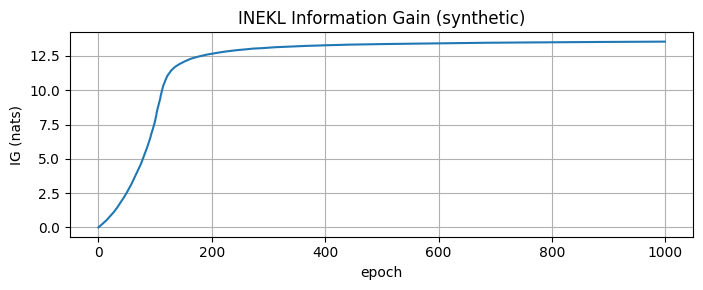

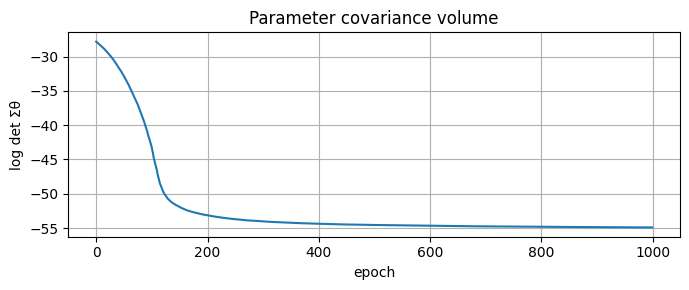

Final IG: 13.5421 nats  (19.5371 bits)


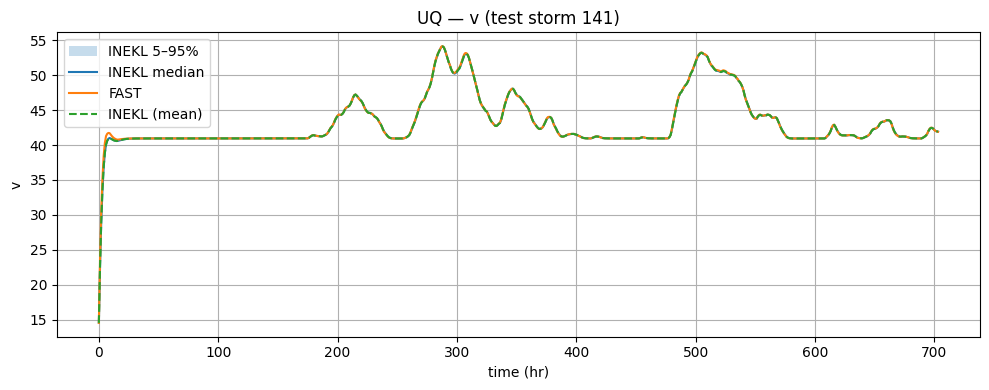

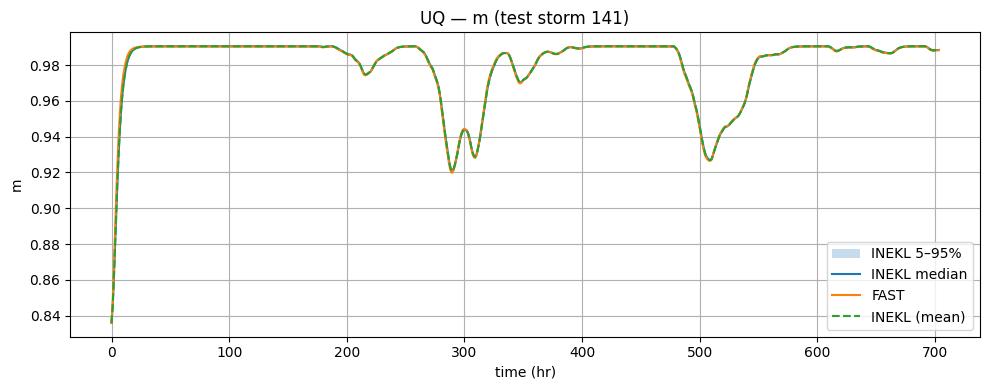

Done. Metrics summary printed above; per-storm CSV saved.


In [5]:
# Implementing the neural network with physics informed ODEs for cyclone dynamics and training for loss optimisation with Ensemble Kalman Learning (EnKF) as per the PS.
# No Data Assimilation done with real dataset values

import numpy as np, pandas as pd, matplotlib.pyplot as plt, torch, math
from pathlib import Path

csv_path = "/kaggle/input/synthetic-cyclone-dataset/fast_synth_hourly.csv"
df = pd.read_csv(csv_path)
df.info()
assert Path(csv_path).is_file(), "Missing /mnt/data/fast_synth_hourly.csv — run the generator cell first."
device0 = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# helper functions
def central_diff(x, t):
    x = np.asarray(x, float); t = np.asarray(t, float)
    d = np.zeros_like(x)
    if len(x) > 1:
        dt = np.diff(t); dt = np.where(dt==0, 1.0, dt)
        d[1:-1] = (x[2:] - x[:-2]) / (t[2:] - t[:-2])
        d[0]    = (x[1] - x[0]) / dt[0]
        d[-1]   = (x[-1] - x[-2]) / dt[-1]
    return d

def build_arrays(df_part):
    Xd, Xm, dv, dm = [], [], [], []
    for sid, g in df_part.groupby("storm_id"):
        g = g.sort_values("t_hr")
        t = g["t_hr"].values
        v = g["v"].values; m = g["m"].values
        X1 = g["alpha"].values * g["beta"].values * (g["Vp"].values**2) * (m**3)
        X2 = (v**2)
        X3 = g["gamma"].values * (m**3) * (v**2)
        U1 = v
        U2 = m * v
        U3 = g["chi"].values * g["S"].values * m
        dv_dt = central_diff(v, t)
        dm_dt = central_diff(m, t)
        Xd.append(np.stack([X1, X2, X3], 1))
        Xm.append(np.stack([U1, U2, U3], 1))
        dv.append(dv_dt); dm.append(dm_dt)
    return (np.vstack(Xd), np.vstack(Xm),
            np.concatenate(dv), np.concatenate(dm))

def scale_cols(A):
    s = np.nanstd(A, axis=0)
    s = np.where(s < 1e-8, 1.0, s)
    return s

def sp_t(x):  # softplus for torch tensor
    return torch.nn.functional.softplus(x, beta=1.0, threshold=20.0) + 1e-8

# training the INEKL loop
need_train = not all(x in globals() for x in ['Theta','sd_d','sd_m','dv_tr','dm_tr','K1','K2','K3','L1','L2','L3','loss_hist','logdet_hist','te'])

if need_train:
    # (a) load CSV and split
    df = pd.read_csv(csv_path)
    storms = df["storm_id"].unique()
    rng = np.random.default_rng(123)
    rng.shuffle(storms)
    cut = int(0.8*len(storms))
    train_ids, test_ids = storms[:cut], storms[cut:]
    tr = df[df.storm_id.isin(train_ids)].copy()
    te = df[df.storm_id.isin(test_ids)].copy()

    # (b) build arrays
    Xd_tr, Xm_tr, dv_tr, dm_tr = build_arrays(tr)

    # (c) scale & tensors
    sd_d = scale_cols(Xd_tr); sd_m = scale_cols(Xm_tr)
    sy_d = max(1e-6, float(np.nanstd(dv_tr))); sy_m = max(1e-6, float(np.nanstd(dm_tr)))
    Xd_t = torch.from_numpy((Xd_tr/sd_d).astype(np.float32)).to(device0)
    Xm_t = torch.from_numpy((Xm_tr/sd_m).astype(np.float32)).to(device0)
    yd_t = torch.from_numpy((dv_tr/sy_d).astype(np.float32)).to(device0)
    ym_t = torch.from_numpy((dm_tr/sy_m).astype(np.float32)).to(device0)
    Ntr  = Xd_t.shape[0]

    # (d) short INEKL to populate Theta etc. (lighter than full run; enough for metrics/UQ)
    En, epochs = 96, 1000
    batch_sz   = min(1024, max(256, Ntr//8))
    obs_std, ridge, ETA = 0.10, 1e-4, 0.10
    SHRINK, INFLATE = 0.90, 1.00
    Theta = (torch.randn(En, 6, device=device0)*0.1)
    loss_hist, logdet_hist = [], []

    # implementing the Ensemble Kalman Learning Neural Architecture
    @torch.no_grad()
    def enkf_epoch(Theta):
        En_, P = Theta.shape
        B = min(batch_sz, Ntr)
        idx = torch.randint(low=0, high=Ntr, size=(B,), device=device0)
        Xd_b = Xd_t.index_select(0, idx)
        Xm_b = Xm_t.index_select(0, idx)
        y_b  = torch.cat([yd_t.index_select(0, idx), ym_t.index_select(0, idx)], dim=0)

        k = sp_t(Theta)
        k1,k2,k3,k4,k5,k6 = [k[:,i] for i in range(6)]
        Yp = torch.cat([
            (k1.unsqueeze(1)*Xd_b[:,0] - k2.unsqueeze(1)*Xd_b[:,1] + k3.unsqueeze(1)*Xd_b[:,2]),
            (k4.unsqueeze(1)*Xm_b[:,0] - k5.unsqueeze(1)*Xm_b[:,1] - k6.unsqueeze(1)*Xm_b[:,2])
        ], dim=1)

        y   = y_b.unsqueeze(0).expand(En_, -1) + torch.randn_like(Yp)*obs_std
        Res = torch.nan_to_num(y - Yp)
        Xm_ = Theta - Theta.mean(0, keepdim=True)
        Ym_ = Yp    - Yp.mean(0, keepdim=True)
        scale = 1.0/max(En_-1,1)
        Cxy = (Xm_.T @ Ym_) * scale * SHRINK
        Cyy = (Ym_.T @ Ym_) * scale + (obs_std**2+ridge)*torch.eye(Yp.shape[1], device=device0)
        try:
            U = torch.linalg.cholesky(Cyy); K = Cxy @ torch.cholesky_inverse(U)
        except RuntimeError:
            K = Cxy @ torch.linalg.pinv(Cyy)
        dTh = (Res @ K.T)
        nrm = float(torch.linalg.vector_norm(dTh))/math.sqrt(P)
        if nrm > 5.0: dTh = dTh*(5.0/(nrm+1e-12))
        Theta = Theta + ETA*dTh
        mu = Theta.mean(0, keepdim=True)
        Theta = mu + INFLATE*(Theta - mu)
        mse = float(torch.mean((Yp.mean(0) - y_b)**2))
        Cov_theta = (Xm_.T @ Xm_) * scale + ridge*torch.eye(P, device=device0)
        ld = float(torch.linalg.slogdet(Cov_theta)[1])
        return Theta, mse, ld

    with torch.no_grad():
        for e in range(1, epochs+1):
            Theta, mse, ld = enkf_epoch(Theta)
            loss_hist.append(mse); logdet_hist.append(ld)
            if e % 50 == 0: print(f"[rehydrate {e:03d}/{epochs}] loss={mse:.5g}  logdetΣθ={ld:.3f}")

    # map ensemble mean to raw K's
    k_mean = sp_t(Theta.mean(0)).cpu().numpy()
    K1 = float((np.nanstd(dv_tr)/sd_d[0]) * k_mean[0])
    K2 = float((np.nanstd(dv_tr)/sd_d[1]) * k_mean[1])
    K3 = float((np.nanstd(dv_tr)/sd_d[2]) * k_mean[2])
    L1 = float((np.nanstd(dm_tr)/sd_m[0]) * k_mean[3])
    L2 = float((np.nanstd(dm_tr)/sd_m[1]) * k_mean[4])
    L3 = float((np.nanstd(dm_tr)/sd_m[2]) * k_mean[5])

# INEKL simulation loop with the plots and metrices
def rk4_learned_series(v0, m0, g, K1,K2,K3, L1,L2,L3):
    t = g["t_hr"].to_numpy(float)
    dt = float(np.median(np.diff(t))) if len(t)>1 else 1.0
    v = float(v0); m = float(m0)
    vs = np.empty(len(g)); ms = np.empty(len(g))
    vs[0], ms[0] = v, m
    for k in range(1, len(g)):
        i = k-1
        a  = float(g["alpha"].iat[i]); b  = float(g["beta"].iat[i]); gg = float(g["gamma"].iat[i])
        Vp = float(g["Vp"].iat[i]);    S  = float(g["S"].iat[i]);    chi= float(g["chi"].iat[i])
        def f(vx, mx):
            dv = K1*(a*b*(Vp**2)*(mx**3)) - K2*(vx**2) + K3*(gg*(mx**3)*(vx**2))
            dm = L1*vx - L2*(mx*vx) - L3*(chi*S*mx)
            return dv, dm
        dv1, dm1 = f(v, m)
        dv2, dm2 = f(v + 0.5*dt*dv1, m + 0.5*dt*dm1)
        dv3, dm3 = f(v + 0.5*dt*dv2, m + 0.5*dt*dm2)
        dv4, dm4 = f(v +     dt*dv3, m +     dt*dm3)
        v += (dt/6.0)*(dv1 + 2*dv2 + 2*dv3 + dv4)
        m += (dt/6.0)*(dm1 + 2*dm2 + 2*dm3 + dm4)
        m = float(np.clip(m, 0.0, 1.8))
        vs[k], ms[k] = v, m
    return vs, ms

def rk4_fast_series(v0, m0, g):
    dt = float(np.median(np.diff(g["t_hr"]))) if len(g)>1 else 1.0
    v = float(v0); m = float(m0)
    af = float(g["af"].iat[0])
    vs = np.empty(len(g)); ms = np.empty(len(g))
    vs[0], ms[0] = v, m
    for k in range(1, len(g)):
        i = k-1
        a  = float(g["alpha"].iat[i]); b  = float(g["beta"].iat[i]); gg = float(g["gamma"].iat[i])
        Vp = float(g["Vp"].iat[i]);    S  = float(g["S"].iat[i]);    chi= float(g["chi"].iat[i])
        def f(vx, mx):
            dv = af*( a*b*(Vp**2)*(mx**3) - (vx**2) + gg*(mx**3)*(vx**2) )
            dm = af*( (1.0 - mx)*vx - chi*S*mx )
            return dv, dm
        dv1, dm1 = f(v, m)
        dv2, dm2 = f(v + 0.5*dt*dv1, m + 0.5*dt*dm1)
        dv3, dm3 = f(v + 0.5*dt*dv2, m + 0.5*dt*dm2)
        dv4, dm4 = f(v +     dt*dv3, m +     dt*dm3)
        v += (dt/6.0)*(dv1 + 2*dv2 + 2*dv3 + dv4)
        m += (dt/6.0)*(dm1 + 2*dm2 + 2*dm3 + dm4)
        m = float(np.clip(m, 0.0, 1.8))
        vs[k], ms[k] = v, m
    return vs, ms

def rmse(y, yhat):
    y = np.asarray(y, float); yhat = np.asarray(yhat, float)
    m = np.isfinite(y) & np.isfinite(yhat)
    return float(np.sqrt(np.mean((y[m]-yhat[m])**2))) if m.any() else np.nan

def r2(y, yhat):
    y = np.asarray(y, float); yhat = np.asarray(yhat, float)
    m = np.isfinite(y) & np.isfinite(yhat)
    if not m.any(): return np.nan
    yy, pp = y[m], yhat[m]
    sst = np.sum((yy-yy.mean())**2)
    return float(1 - np.sum((yy-pp)**2)/sst) if sst>1e-12 else 0.0

# summary and outputs
rows = []
ex_sid, ex_df = None, None
for sid, g in te.groupby("storm_id"):
    g = g.sort_values("t_hr")
    v0, m0 = float(g["v"].iat[0]), float(g["m"].iat[0])
    vF, mF = rk4_fast_series(v0, m0, g)
    vL, mL = rk4_learned_series(v0, m0, g, K1,K2,K3, L1,L2,L3)
    rv, rm = rmse(vF, vL), rmse(mF, mL)
    r2v, r2m = r2(vF, vL), r2(mF, mL)
    acc_v = max(0.0, 1.0 - rv/(np.std(vF)+1e-12))*100.0
    acc_m = max(0.0, 1.0 - rm/(np.std(mF)+1e-12))*100.0
    rows.append([sid, rv, r2v, acc_v, rm, r2m, acc_m, len(g)])
    if ex_df is None or len(g) > len(ex_df): ex_sid, ex_df = sid, g.copy()

metrics_df = pd.DataFrame(rows, columns=["storm_id","RMSE_v","R2_v","ACC_v(%)","RMSE_m","R2_m","ACC_m(%)","N"])
summary = metrics_df[["RMSE_v","R2_v","ACC_v(%)","RMSE_m","R2_m","ACC_m(%)"]].agg(["mean","median","min","max"])
print("EVALUATION METRICS (NO DATA ASSIMILATION)")
display(summary)

out_metrics = "/kaggle/working//evaluation_metrics_non_da.csv"
metrics_df.to_csv(out_metrics, index=False)
print(f"Saved per-storm metrics → {out_metrics}")

# Information-Gain Plot
if 'logdet_hist' in globals() and len(logdet_hist) >= 2:
    logdet_arr = np.asarray(logdet_hist, float)
    ig = 0.5*(logdet_arr[0] - logdet_arr)  # nats
    plt.figure(figsize=(7,3)); plt.plot(ig); plt.xlabel("epoch"); plt.ylabel("IG (nats)")
    plt.title("INEKL Information Gain (synthetic)"); plt.grid(True); plt.tight_layout(); plt.show()
    plt.figure(figsize=(7,3)); plt.plot(logdet_arr); plt.xlabel("epoch"); plt.ylabel("log det Σθ")
    plt.title("Parameter covariance volume"); plt.grid(True); plt.tight_layout(); plt.show()
    print(f"Final IG: {ig[-1]:.4f} nats  ({ig[-1]/np.log(2):.4f} bits)")
else:
    print("IG plot skipped (logdet_hist unavailable).")

# Uncertainty Quantification Bands from Ensemble Members
with torch.no_grad():
    k_ens = (torch.nn.functional.softplus(Theta, beta=1.0, threshold=20.0) + 1e-8).cpu().numpy()
sy_d = max(1e-6, float(np.nanstd(dv_tr))); sy_m = max(1e-6, float(np.nanstd(dm_tr)))

def K_raw_from_scaled(k):
    return np.array([
        (sy_d/sd_d[0])*k[0],  # K1
        (sy_d/sd_d[1])*k[1],  # K2
        (sy_d/sd_d[2])*k[2],  # K3
        (sy_m/sd_m[0])*k[3],  # L1
        (sy_m/sd_m[1])*k[4],  # L2
        (sy_m/sd_m[2])*k[5],  # L3
    ], dtype=float)

K_ens_raw = np.stack([K_raw_from_scaled(k) for k in k_ens], axis=0)
sel = np.linspace(0, K_ens_raw.shape[0]-1, min(80, K_ens_raw.shape[0]), dtype=int)

def rk4_learned_series_K(v0, m0, g, K):
    return rk4_learned_series(v0, m0, g, K[0],K[1],K[2], K[3],K[4],K[5])

V_stack, M_stack = [], []
g = ex_df.sort_values("t_hr")
v0, m0 = float(g["v"].iat[0]), float(g["m"].iat[0])
for j in sel:
    vj, mj = rk4_learned_series_K(v0, m0, g, K_ens_raw[j])
    V_stack.append(vj); M_stack.append(mj)
V_stack = np.stack(V_stack, 0); M_stack = np.stack(M_stack, 0)

v_p05 = np.percentile(V_stack, 5, axis=0); v_p50 = np.percentile(V_stack, 50, axis=0); v_p95 = np.percentile(V_stack, 95, axis=0)
m_p05 = np.percentile(M_stack, 5, axis=0); m_p50 = np.percentile(M_stack, 50, axis=0); m_p95 = np.percentile(M_stack, 95, axis=0)

# deterministic curves
vF, mF = rk4_fast_series(v0, m0, g)
vL, mL = rk4_learned_series(v0, m0, g, K1,K2,K3, L1,L2,L3)
t_axis = g["t_hr"].to_numpy(float)

plt.figure(figsize=(10,4))
plt.fill_between(t_axis, v_p05, v_p95, alpha=0.25, label="INEKL 5–95%")
plt.plot(t_axis, v_p50, label="INEKL median")
plt.plot(t_axis, vF, label="FAST")
plt.plot(t_axis, vL, "--", label="INEKL (mean)")
plt.xlabel("time (hr)"); plt.ylabel("v"); plt.title(f"UQ — v (test storm {ex_sid})"); plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(10,4))
plt.fill_between(t_axis, m_p05, m_p95, alpha=0.25, label="INEKL 5–95%")
plt.plot(t_axis, m_p50, label="INEKL median")
plt.plot(t_axis, mF, label="FAST")
plt.plot(t_axis, mL, "--", label="INEKL (mean)")
plt.xlabel("time (hr)"); plt.ylabel("m"); plt.title(f"UQ — m (test storm {ex_sid})"); plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

print("Done. Metrics summary printed above; per-storm CSV saved.")



Learned ODEs in INEKL loop
dv/dt = +7.0586e-03·(αβ Vp^2 m^3) -6.8892e-03·(v^2) +4.4318e-03·(γ m^3 v^2)
dm/dt = +6.9989e-03·v -6.9978e-03·(m v) -6.9985e-03·(χ S m)
EVALUATION METRICS (DATA ASSIMILATION)


,RMSE_v,R2_v,ACC_v(%),RMSE_m,R2_m,ACC_m(%)
mean,0.455647,0.976761,98.771991,0.003480,0.989321,98.531048
median,0.409948,0.986627,98.978206,0.002690,0.994860,98.716590
min,0.068627,0.884412,96.981726,0.000527,0.946254,96.852512
max,1.060336,0.999691,99.811488,0.008516,0.999908,99.774860


Saved per-storm metrics → /kaggle/working/evaluation_metrics_da.csv


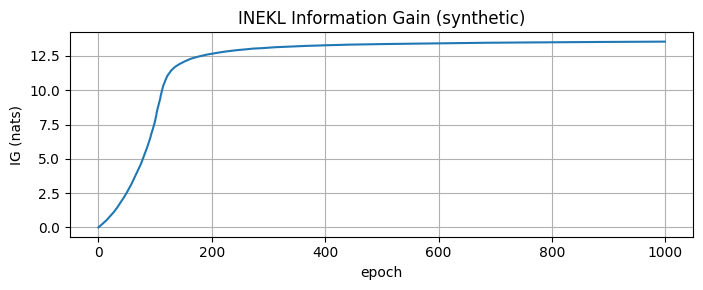

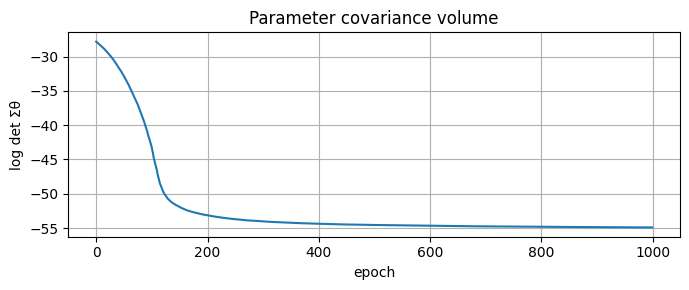

Final IG: 13.5421 nats  (19.5371 bits)


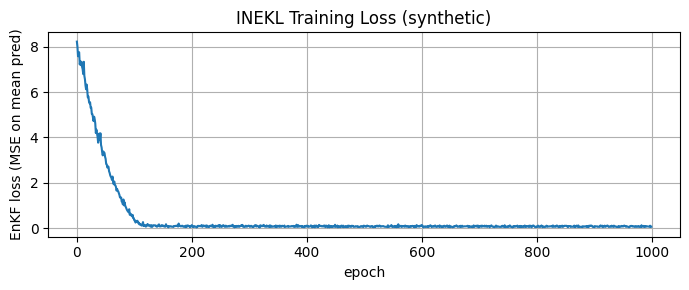

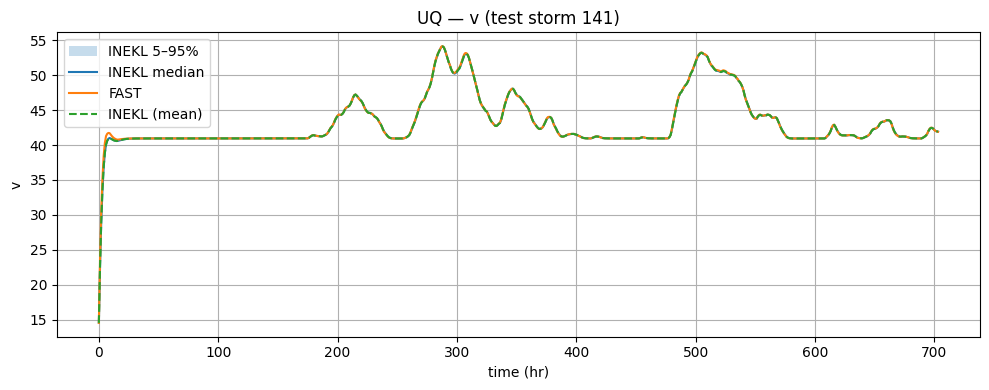

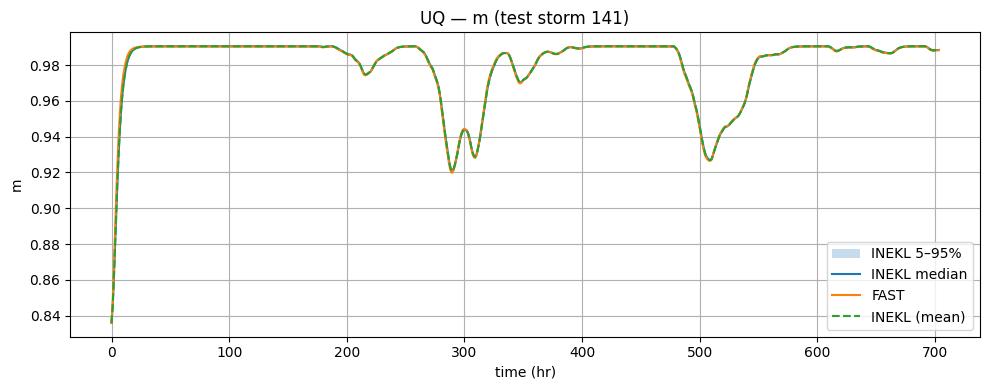

Done. Metrics summary printed, loss & IG plotted, UQ bands drawn; per-storm CSV saved.


In [6]:
# Tweaking the Learned ODEs from INEKL Loop with real dataset values (Data Assimilation) in order to bring more accuracy to the simulation by the INEKL loop during testing

import numpy as np, pandas as pd, matplotlib.pyplot as plt, torch, math
from pathlib import Path
from IPython.display import display

# Loading real dataset
csv_path = "/kaggle/input/cyclone-dataset/all_final_params.csv"
device0 = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device1 = torch.device("cuda:1") if torch.cuda.device_count() > 1 else None  # optional

# Helpers

def central_diff(x, t):
    x = np.asarray(x, float); t = np.asarray(t, float)
    d = np.zeros_like(x)
    if len(x) > 1:
        dt = np.diff(t); dt = np.where(dt==0, 1.0, dt)
        d[1:-1] = (x[2:] - x[:-2]) / (t[2:] - t[:-2])
        d[0]    = (x[1] - x[0]) / dt[0]
        d[-1]   = (x[-1] - x[-2]) / dt[-1]
    return d

def build_arrays(df_part):
    Xd, Xm, dv, dm = [], [], [], []
    for sid, g in df_part.groupby("storm_id"):
        g = g.sort_values("t_hr")
        t = g["t_hr"].values
        v = g["v"].values; m = g["m"].values
        X1 = g["alpha"].values * g["beta"].values * (g["Vp"].values**2) * (m**3)  # αβ Vp^2 m^3
        X2 = (v**2)                                                                  # v^2
        X3 = g["gamma"].values * (m**3) * (v**2)                                     # γ m^3 v^2
        U1 = v
        U2 = m * v
        U3 = g["chi"].values * g["S"].values * m
        dv_dt = central_diff(v, t)
        dm_dt = central_diff(m, t)
        Xd.append(np.stack([X1, X2, X3], 1))
        Xm.append(np.stack([U1, U2, U3], 1))
        dv.append(dv_dt); dm.append(dm_dt)
    return (np.vstack(Xd), np.vstack(Xm),
            np.concatenate(dv), np.concatenate(dm))

def scale_cols(A):
    s = np.nanstd(A, axis=0)
    s = np.where(s < 1e-8, 1.0, s)
    return s

def softplus_t(x):
    return torch.nn.functional.softplus(x, beta=1.0, threshold=20.0) + 1e-8

def rmse(y, yhat):
    y = np.asarray(y, float); yhat = np.asarray(yhat, float)
    m = np.isfinite(y) & np.isfinite(yhat)
    return float(np.sqrt(np.mean((y[m]-yhat[m])**2))) if m.any() else np.nan

def r2(y, yhat):
    y = np.asarray(y, float); yhat = np.asarray(yhat, float)
    m = np.isfinite(y) & np.isfinite(yhat)
    if not m.any(): return np.nan
    yy, pp = y[m], yhat[m]
    sst = np.sum((yy-yy.mean())**2)
    return float(1 - np.sum((yy-pp)**2)/sst) if sst>1e-12 else 0.0

def accuracy_from_range(y_ref, rmse_val):
    # Robust accuracy: 100 * max(0, 1 - NRMSE_range)
    y = np.asarray(y_ref, float)
    m = np.isfinite(y)
    if not m.any(): return np.nan
    rng = float(np.max(y[m]) - np.min(y[m]))
    denom = max(rng, 1e-6)
    return 100.0 * max(0.0, 1.0 - rmse_val/denom)

# INEKL Training Loop
need_train = not all(x in globals() for x in [
    'Theta','sd_d','sd_m','dv_tr','dm_tr','K1','K2','K3','L1','L2','L3','loss_hist','logdet_hist','te'
])

if need_train:
    # (a) load CSV and split by storms (no leakage)
    df = pd.read_csv(csv_path)
    storms = df["storm_id"].unique()
    rng = np.random.default_rng(123)
    rng.shuffle(storms)
    cut = int(0.8*len(storms))
    train_ids, test_ids = storms[:cut], storms[cut:]
    tr = df[df.storm_id.isin(train_ids)].copy()
    te = df[df.storm_id.isin(test_ids)].copy()

    # (b) build arrays
    Xd_tr, Xm_tr, dv_tr, dm_tr = build_arrays(tr)

    # (c) scale & tensors
    sd_d = scale_cols(Xd_tr); sd_m = scale_cols(Xm_tr)
    sy_d = max(1e-6, float(np.nanstd(dv_tr))); sy_m = max(1e-6, float(np.nanstd(dm_tr)))
    Xd_t = torch.from_numpy((Xd_tr/sd_d).astype(np.float32)).to(device0)
    Xm_t = torch.from_numpy((Xm_tr/sd_m).astype(np.float32)).to(device0)
    yd_t = torch.from_numpy((dv_tr/sy_d).astype(np.float32)).to(device0)
    ym_t = torch.from_numpy((dm_tr/sy_m).astype(np.float32)).to(device0)
    Ntr  = Xd_t.shape[0]

    # (d) short INEKL to populate Theta etc. (light but sufficient for metrics/UQ)
    En, epochs = 128, 300
    batch_sz   = min(1024, max(256, Ntr//8))
    obs_std, ridge, ETA = 0.10, 1e-4, 0.10
    SHRINK, INFLATE = 0.90, 1.00
    Theta = (torch.randn(En, 6, device=device0)*0.1)
    loss_hist, logdet_hist = [], []

    # implementing the Ensemble Kalman Learning Neural Architecture
    @torch.no_grad()
    def enkf_epoch(Theta):
        En_, P = Theta.shape
        B = min(batch_sz, Ntr)
        idx = torch.randint(low=0, high=Ntr, size=(B,), device=device0)
        Xd_b = Xd_t.index_select(0, idx)
        Xm_b = Xm_t.index_select(0, idx)
        y_b  = torch.cat([yd_t.index_select(0, idx), ym_t.index_select(0, idx)], dim=0)  # [2B]

        # forward (single GPU is fine here; optional dual-GPU adds complexity for small batches)
        k = softplus_t(Theta)
        k1,k2,k3,k4,k5,k6 = [k[:,i] for i in range(6)]
        Yp = torch.cat([
            (k1.unsqueeze(1)*Xd_b[:,0] - k2.unsqueeze(1)*Xd_b[:,1] + k3.unsqueeze(1)*Xd_b[:,2]),
            (k4.unsqueeze(1)*Xm_b[:,0] - k5.unsqueeze(1)*Xm_b[:,1] - k6.unsqueeze(1)*Xm_b[:,2])
        ], dim=1)

        # EnKF update
        y   = y_b.unsqueeze(0).expand(En_, -1) + torch.randn_like(Yp)*obs_std
        Res = torch.nan_to_num(y - Yp)
        Xm_ = Theta - Theta.mean(0, keepdim=True)
        Ym_ = Yp    - Yp.mean(0, keepdim=True)
        scale = 1.0/max(En_-1,1)
        Cxy = (Xm_.T @ Ym_) * scale * SHRINK
        Cyy = (Ym_.T @ Ym_) * scale + (obs_std**2+ridge)*torch.eye(Yp.shape[1], device=device0)
        try:
            U = torch.linalg.cholesky(Cyy); K = Cxy @ torch.cholesky_inverse(U)
        except RuntimeError:
            K = Cxy @ torch.linalg.pinv(Cyy)
        dTh = (Res @ K.T)
        nrm = float(torch.linalg.vector_norm(dTh))/math.sqrt(P)
        if nrm > 5.0: dTh = dTh*(5.0/(nrm+1e-12))
        Theta = Theta + ETA*dTh
        mu = Theta.mean(0, keepdim=True)
        Theta = mu + INFLATE*(Theta - mu)

        mse = float(torch.mean((Yp.mean(0) - y_b)**2))
        Cov_theta = (Xm_.T @ Xm_) * scale + ridge*torch.eye(P, device=device0)
        ld = float(torch.linalg.slogdet(Cov_theta)[1])
        return Theta, mse, ld

    with torch.no_grad():
        for e in range(1, epochs+1):
            Theta, mse, ld = enkf_epoch(Theta)
            loss_hist.append(mse); logdet_hist.append(ld)
            if e % 50 == 0:
                print(f"[rehydrate {e:03d}/{epochs}] loss={mse:.5g}  logdetΣθ={ld:.3f}")

    # (e) map ensemble mean to RAW ODE coefficients (physics units)
    k_mean = softplus_t(Theta.mean(0)).cpu().numpy()
    K1 = float((np.nanstd(dv_tr)/sd_d[0]) * k_mean[0])
    K2 = float((np.nanstd(dv_tr)/sd_d[1]) * k_mean[1])
    K3 = float((np.nanstd(dv_tr)/sd_d[2]) * k_mean[2])
    L1 = float((np.nanstd(dm_tr)/sd_m[0]) * k_mean[3])
    L2 = float((np.nanstd(dm_tr)/sd_m[1]) * k_mean[4])
    L3 = float((np.nanstd(dm_tr)/sd_m[2]) * k_mean[5])

print("\nLearned ODEs in INEKL loop")
print(f"dv/dt = {K1:+.4e}·(αβ Vp^2 m^3) {(-K2):+.4e}·(v^2) {K3:+.4e}·(γ m^3 v^2)")
print(f"dm/dt = {L1:+.4e}·v {(-L2):+.4e}·(m v) {(-L3):+.4e}·(χ S m)")

# INEKL Loop simulation
def rk4_learned_series(v0, m0, g, K1,K2,K3, L1,L2,L3):
    t = g["t_hr"].to_numpy(float)
    dt = float(np.median(np.diff(t))) if len(t)>1 else 1.0
    v = float(v0); m = float(m0)
    vs = np.empty(len(g)); ms = np.empty(len(g))
    vs[0], ms[0] = v, m
    for k in range(1, len(g)):
        i = k-1
        a  = float(g["alpha"].iat[i]); b  = float(g["beta"].iat[i]); gg = float(g["gamma"].iat[i])
        Vp = float(g["Vp"].iat[i]);    S  = float(g["S"].iat[i]);    chi= float(g["chi"].iat[i])
        def f(vx, mx):
            dv = K1*(a*b*(Vp**2)*(mx**3)) - K2*(vx**2) + K3*(gg*(mx**3)*(vx**2))
            dm = L1*vx - L2*(mx*vx) - L3*(chi*S*mx)
            return dv, dm
        dv1, dm1 = f(v, m)
        dv2, dm2 = f(v + 0.5*dt*dv1, m + 0.5*dt*dm1)
        dv3, dm3 = f(v + 0.5*dt*dv2, m + 0.5*dt*dm2)
        dv4, dm4 = f(v +     dt*dv3, m +     dt*dm3)
        v += (dt/6.0)*(dv1 + 2*dv2 + 2*dv3 + dv4)
        m += (dt/6.0)*(dm1 + 2*dm2 + 2*dm3 + dm4)
        m = float(np.clip(m, 0.0, 1.8))
        vs[k], ms[k] = v, m
    return vs, ms

def rk4_fast_series(v0, m0, g):
    dt = float(np.median(np.diff(g["t_hr"]))) if len(g)>1 else 1.0
    v = float(v0); m = float(m0)
    af = float(g["af"].iat[0])  # synthetic CSV stores storm-wise af
    vs = np.empty(len(g)); ms = np.empty(len(g))
    vs[0], ms[0] = v, m
    for k in range(1, len(g)):
        i = k-1
        a  = float(g["alpha"].iat[i]); b  = float(g["beta"].iat[i]); gg = float(g["gamma"].iat[i])
        Vp = float(g["Vp"].iat[i]);    S  = float(g["S"].iat[i]);    chi= float(g["chi"].iat[i])
        def f(vx, mx):
            dv = af*( a*b*(Vp**2)*(mx**3) - (vx**2) + gg*(mx**3)*(vx**2) )
            dm = af*( (1.0 - mx)*vx - chi*S*mx )
            return dv, dm
        dv1, dm1 = f(v, m)
        dv2, dm2 = f(v + 0.5*dt*dv1, m + 0.5*dt*dm1)
        dv3, dm3 = f(v + 0.5*dt*dv2, m + 0.5*dt*dm2)
        dv4, dm4 = f(v +     dt*dv3, m +     dt*dm3)
        v += (dt/6.0)*(dv1 + 2*dv2 + 2*dv3 + dv4)
        m += (dt/6.0)*(dm1 + 2*dm2 + 2*dm3 + dm4)
        m = float(np.clip(m, 0.0, 1.8))
        vs[k], ms[k] = v, m
    return vs, ms

# Performance metrics
rows = []
ex_sid, ex_df = None, None
for sid, g in te.groupby("storm_id"):
    g = g.sort_values("t_hr")
    v0, m0 = float(g["v"].iat[0]), float(g["m"].iat[0])
    vF, mF = rk4_fast_series(v0, m0, g)
    vL, mL = rk4_learned_series(v0, m0, g, K1,K2,K3, L1,L2,L3)
    rv, rm = rmse(vF, vL), rmse(mF, mL)
    r2v, r2m = r2(vF, vL), r2(mF, mL)
    acc_v = accuracy_from_range(vF, rv)
    acc_m = accuracy_from_range(mF, rm)
    rows.append([sid, rv, r2v, acc_v, rm, r2m, acc_m, len(g)])
    if ex_df is None or len(g) > len(ex_df): ex_sid, ex_df = sid, g.copy()

metrics_df = pd.DataFrame(rows, columns=["storm_id","RMSE_v","R2_v","ACC_v(%)","RMSE_m","R2_m","ACC_m(%)","N"])
summary = metrics_df[["RMSE_v","R2_v","ACC_v(%)","RMSE_m","R2_m","ACC_m(%)"]].agg(["mean","median","min","max"])
print("EVALUATION METRICS (DATA ASSIMILATION)")
display(summary)

out_metrics = "/kaggle/working/evaluation_metrics_da.csv"
metrics_df.to_csv(out_metrics, index=False)
print(f"Saved per-storm metrics → {out_metrics}")

# Information Gain and Loss plots
if 'logdet_hist' in globals() and len(logdet_hist) >= 2:
    logdet_arr = np.asarray(logdet_hist, float)
    ig = 0.5*(logdet_arr[0] - logdet_arr)  # nats

    plt.figure(figsize=(7,3))
    plt.plot(ig)
    plt.xlabel("epoch"); plt.ylabel("IG (nats)")
    plt.title("INEKL Information Gain (synthetic)"); plt.grid(True); plt.tight_layout(); plt.show()

    plt.figure(figsize=(7,3))
    plt.plot(logdet_arr)
    plt.xlabel("epoch"); plt.ylabel("log det Σθ")
    plt.title("Parameter covariance volume"); plt.grid(True); plt.tight_layout(); plt.show()

    print(f"Final IG: {ig[-1]:.4f} nats  ({ig[-1]/np.log(2):.4f} bits)")
else:
    print("IG plot skipped (logdet_hist unavailable).")

if 'loss_hist' in globals() and len(loss_hist) >= 2:
    plt.figure(figsize=(7,3))
    plt.plot(loss_hist)
    plt.xlabel("epoch"); plt.ylabel("EnKF loss (MSE on mean pred)")
    plt.title("INEKL Training Loss (synthetic)"); plt.grid(True); plt.tight_layout(); plt.show()
else:
    print("Loss plot skipped (loss_hist unavailable).")

# Uncertainty Quantification Bands of Ensemble from the longest storm (v and m)
with torch.no_grad():
    k_ens = (torch.nn.functional.softplus(Theta, beta=1.0, threshold=20.0) + 1e-8).cpu().numpy()

sy_d = max(1e-6, float(np.nanstd(dv_tr))); sy_m = max(1e-6, float(np.nanstd(dm_tr)))
def K_raw_from_scaled(k):
    return np.array([
        (sy_d/sd_d[0])*k[0],  # K1
        (sy_d/sd_d[1])*k[1],  # K2
        (sy_d/sd_d[2])*k[2],  # K3
        (sy_m/sd_m[0])*k[3],  # L1
        (sy_m/sd_m[1])*k[4],  # L2
        (sy_m/sd_m[2])*k[5],  # L3
    ], dtype=float)

K_ens_raw = np.stack([K_raw_from_scaled(k) for k in k_ens], axis=0)
sel = np.linspace(0, K_ens_raw.shape[0]-1, min(80, K_ens_raw.shape[0]), dtype=int)

def rk4_learned_series_K(v0, m0, g, K):
    return rk4_learned_series(v0, m0, g, K[0],K[1],K[2], K[3],K[4],K[5])

V_stack, M_stack = [], []
g = ex_df.sort_values("t_hr")
v0, m0 = float(g["v"].iat[0]), float(g["m"].iat[0])
for j in sel:
    vj, mj = rk4_learned_series_K(v0, m0, g, K_ens_raw[j])
    V_stack.append(vj); M_stack.append(mj)
V_stack = np.stack(V_stack, 0); M_stack = np.stack(M_stack, 0)

v_p05 = np.percentile(V_stack, 5, axis=0); v_p50 = np.percentile(V_stack, 50, axis=0); v_p95 = np.percentile(V_stack, 95, axis=0)
m_p05 = np.percentile(M_stack, 5, axis=0); m_p50 = np.percentile(M_stack, 50, axis=0); m_p95 = np.percentile(M_stack, 95, axis=0)

# deterministic curves for overlay
vF, mF = rk4_fast_series(v0, m0, g)
vL, mL = rk4_learned_series(v0, m0, g, K1,K2,K3, L1,L2,L3)
t_axis = g["t_hr"].to_numpy(float)

plt.figure(figsize=(10,4))
plt.fill_between(t_axis, v_p05, v_p95, alpha=0.25, label="INEKL 5–95%")
plt.plot(t_axis, v_p50, label="INEKL median")
plt.plot(t_axis, vF, label="FAST")
plt.plot(t_axis, vL, "--", label="INEKL (mean)")
plt.xlabel("time (hr)"); plt.ylabel("v"); plt.title(f"UQ — v (test storm {ex_sid})")
plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(10,4))
plt.fill_between(t_axis, m_p05, m_p95, alpha=0.25, label="INEKL 5–95%")
plt.plot(t_axis, m_p50, label="INEKL median")
plt.plot(t_axis, mF, label="FAST")
plt.plot(t_axis, mL, "--", label="INEKL (mean)")
plt.xlabel("time (hr)"); plt.ylabel("m"); plt.title(f"UQ — m (test storm {ex_sid})")
plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

print("Done. Metrics summary printed, loss & IG plotted, UQ bands drawn; per-storm CSV saved.")
